# Homework 1: Professionalism & Resposibility 

## Data Aquisition

I will begin by importing all necessary modules and reading in the dataset "dinosaur_subset.xlsx" which is located in the repo. This is a subset of English Wikipedia containing dinosaur related articles. 

In [ ]:
# Import necessary modules
import json, time, urllib.parse
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt 

# read in subset of articles 
dinosaurs = pd.read_excel (r'C:\\Users\\franc\\dinosaur_subset.xlsx')

To collect the data on article views, I will use the REST Pageviews API. This will provide the total article views for each month broken down by access type: desktop, mobile web, and mobile app. I have defined the constants that are required for the API call to run and the function that will be called to obtain the data for each article title within the dinosaur subset.

In [ ]:
###  Define Constants for the API call 
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
REQUEST_HEADERS = {
    'User-Agent': '<fasw@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}
ARTICLE_TITLES = dinosaurs.name.values.tolist() # list of dinosaur articles to run the API for

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this will be changed for the following access types 
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    
} 

### Define Function to Obtain Page Views 
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

The API call will take in one article title at a time and return a Json object with the access data for that title. To collect all the desktop data I will run the API call for each article title within the list of dinosaur article titles and merge them together. To do so, I have defined the merge function to take two Json objects and return one merged Json object. Once the response data has been collected into one Json dictionary, I will use the json.dumps() function to convert the access data into a string. This will then be saved in the dino_monthly_desktop_201507-202210.json file. 

In [ ]:
# Define function to merge two Json objects together 
def merge(json_obj_1, json_obj_2):
    items = json_obj_1['items'] + json_obj_2['items']
    return { 'items': items }

In [ ]:
#  collect all data for articles with desktop access type
length = len(ARTICLE_TITLES)
desktop_articles  =  request_pageviews_per_article(ARTICLE_TITLES[0])
for x in range(1, length-1): 
    title_x = request_pageviews_per_article(ARTICLE_TITLES[x])
    desktop_articles = merge(desktop_articles, title_x)

# convert to a string
desktop_articles_string = (json.dumps(desktop_articles, indent=4)) 
# write to file
with open("dino_monthly_desktop_201507-202210.json", "w") as outfile:
    outfile.write(desktop_articles_string)

To collect the mobile data, I will repeat the same process as with the desktop data for both access types: mobile-app and mobile-web. I will first set the parameters of the API call to have the updated access type, and then call the API with the updated parameters for each article in the dataset. 

In [ ]:
# adjust access type to mobile - app data 
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # adjusted to get mobile app data 
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    
}

# collect all data for articles with mobile web access type
mobile_app_articles  =  request_pageviews_per_article(ARTICLE_TITLES[0], request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)
for x in range(1, length-1): 
    title_x = request_pageviews_per_article(ARTICLE_TITLES[x])
    mobile_app_articles = merge(mobile_app_articles, title_x)
    

In [ ]:
# adjust access type to mobile - web data 
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # adjusted to get mobile web data 
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    
}

# collect all data for articles with mobile web access type
mobile_web_articles  =  request_pageviews_per_article(ARTICLE_TITLES[0], request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE) 
for x in range(1, length-1): 
    title_x = request_pageviews_per_article(ARTICLE_TITLES[x]) 
    mobile_web_articles = merge(mobile_web_articles, title_x)   

Using the merge function defined earlier, I will combined the two mobile objects into one Json object containing all of the data for mobile access. Once they have been merged into one Json dictionary, I will use the json.dumps() function to convert the access data into a string. This will then be saved in the dino_monthly_201507-202210.json file.

In [ ]:
# merge the objects and convert to a string
mobile_articles = merge(mobile_app_articles, mobile_web_articles)
mobile_articles_string = (json.dumps(mobile_articles, indent=4)) 

# write to file
with open("dino_monthly_mobile_201507-202210.json", "w") as outfile:
    outfile.write(mobile_articles_string)

To create a dataset with articles from all access types, I will use the merge function again to merge the mobile and desktop objects. Once they are merged into one Json dictionary, I will convert to a string and save it in the dino_monthly_cumulative_201507-202210.json file. 

In [ ]:
# merge the objects and convert to a string
cumulative_articles = merge(mobile_articles, desktop_articles)
cumulative_articles_string = (json.dumps(cumulative_articles, indent=4)) 

# write to file
with open("dino_monthly_cumulative_201507-202210.json", "w") as outfile:
    outfile.write(mobile_articles_string)

### Data Analysis

#### Maximum and Minimum Average Plot

The first analysis I will conduct is of the maximum and minimum averages of the articles over time for desktop and mobile access types. I will first read in the data that was cleaned in the first section of this notebook and normalize it. 

In [ ]:
# Read in Json data for mobile and desktop views and normalize
dict_mobile = json.loads(mobile_articles_string)
mobile = pd.json_normalize(dict_mobile['items']) 

dict_desktop = json.loads(desktop_articles_string)
desktop = pd.json_normalize(dict_desktop['items']) 

I intend to create a timeseries plot, so I need to format the timestamp column as a date so that it can be converted to a datetime variable. I have defined a function that will take in the timestamps of a Json object and rewrite them in the format of 'YYYY-MM-DD'. I will apply this function to the timestamp column of both the desktop and mobile files and then change the datatype of the timestamp column to a datetime. 

In [ ]:
# Define function to correctly format timestamp column for time series plot
def format_timestamp(x):
    # identify the year, month, and day from the input
    y = int(str([x])[2:6]) 
    m = int(str([x])[6:8]) 
    d = int(str([x])[8:10]) 
    # return the reformated timestamp 
    return(dt.date(y, m, d).strftime("%Y-%m-%d"))

In [ ]:
# Format timestamp column correctly to allow for conversion to a datetime 
mobile['timestamp'] = mobile['timestamp'].apply(format_timestamp)
desktop['timestamp'] = desktop['timestamp'].apply(format_timestamp)

# Changing the datatype to timestamp
mobile["timestamp"] = mobile["timestamp"].astype("datetime64")
desktop["timestamp"] = desktop["timestamp"].astype("datetime64")

I will group by the article names and their timestamp to determine the article with the highest average views for the desktop and mobile access types. I will create a dataframe containing the data for each of the curves: maximum mobile, maximum desktop, minimum mobile and minimum desktop. Then I will merge those objects together and index them on the timestamp. 

In [ ]:
# Calculate max and min view counts for desktop and mobile access types
MaxMobile = mobile.groupby(['timestamp'])['views'].max().reset_index()
MaxMobile.rename(columns={'views': 'MaxMobile'}, inplace=True)

MinMobile = mobile.groupby(['timestamp'])['views'].min().reset_index()
MinMobile.rename(columns={'views': 'MinMobile'}, inplace=True)

MaxDesktop = desktop.groupby(['timestamp'])['views'].max().reset_index()
MaxDesktop.rename(columns={'views': 'MaxDesktop'}, inplace=True)

MinDesktop = desktop.groupby(['timestamp'])['views'].min().reset_index()
MinDesktop.rename(columns={'views': 'MinDesktop'}, inplace=True)

# Merge datasets together and index by timestamp
max_min_views_mobile = pd.merge(MaxMobile, MinMobile)
max_min_views_desktop = pd.merge(MaxDesktop, MinDesktop)
max_min_views = pd.merge(max_min_views_mobile, max_min_views_desktop)
max_min_views_indexed = max_min_views.set_index('timestamp')

Now that I have the indexed dataframe with the four curves, I will create the plot and save it as Max_Min_Article_Views.png. 

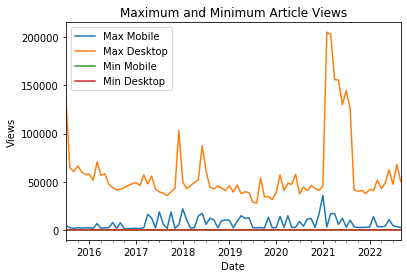

In [462]:
# Plot the curves 
max_min_views_indexed['MaxMobile'].plot(legend='True', label = 'Max Mobile')
max_min_views_indexed['MaxDesktop'].plot(legend='True', label = 'Max Desktop')
max_min_views_indexed['MinMobile'].plot(legend='True', label = 'Min Mobile')
max_min_views_indexed['MinDesktop'].plot(legend='True', label = 'Min Desktop')
plt.xlabel("Date")
plt.ylabel("Views")
plt.title("Maximum and Minimum Article Views")
plt.savefig('Max_Min_Article_Views.png', bbox_inches='tight')
plt.show()

#### Top 10 Peak Page Views Plot

The second analysis that I will conduct will look at the top ten articles with the largest (peak) page views over the entire time for desktop and mobile access type. I will first identify the top ten articles with the largest peak values for the mobile access type. I do this by grouping by the article name and then finding the maximum number of views that an article received during any timestamp throughout the time period. Then I will sort these maximum values and identify which indexes align with the top ten highest values. Then I will match the article names in the dataset to the indexes to identify which were the maximum ten values. Finally, I will use that list of ten article names to filter the dataset to only include those articles and I will index by the timestamp. 

In [ ]:
# find the maximum view count for each article title with mobile access type
mobile_max_monthly_views_by_article = mobile.groupby('article')['views'].max()

# identify which locations in the mobile max views array have the highest ten values
mobile_max_monthly_views_by_article_sorted_indexes = np.argsort(mobile_max_monthly_views_by_article, 10)
mobile_max_monthly_views_by_article_sorted = mobile_max_monthly_views_by_article[mobile_max_monthly_views_by_article_sorted_indexes]
mobile_articles_with_max_views = mobile_max_monthly_views_by_article_sorted[-10:]

# match the article names in the array to the indexes identified to obtain a list of the articles with the top ten peak views 
length = len(mobile.article)
indexes = []
for x in range(1, length-1): 
        result = mobile.article[x] in mobile_articles_with_max_views.index
        if(result == True): 
            indexes.append(x)

# filter the max views dataframe to only include articles that are in the list of the top ten articles by their peak views
mobile_max_views = mobile[mobile.index.isin(indexes)]
mobile_max_views_indexed = mobile_max_views.set_index('timestamp') # index the data 

# add a suffix to the article title to provide clarity in the plot 
suffix = ' (Mobile)'
mobile_max_views_indexed.article = [title + suffix for title in mobile_max_views_indexed.article]

In [ ]:
# find the maximum view count for each article title with desktop access type
desktop_max_monthly_views_by_article = desktop.groupby('article')['views'].max()

# identify which locations in the desktop max views array have the highest ten values
desktop_max_monthly_views_by_article_sorted_indexes = np.argsort(desktop_max_monthly_views_by_article, 10)
desktop_max_monthly_views_by_article_sorted = desktop_max_monthly_views_by_article[mobile_max_monthly_views_by_article_sorted_indexes]
desktop_articles_with_max_views = desktop_max_monthly_views_by_article_sorted[-10:]

# match the article names in the array to the indexes identified to obtain a list of the articles with the top ten peak views 
length = len(desktop.article)
indexes = []
for x in range(1, length-1): 
        result = desktop.article[x] in desktop_articles_with_max_views.index
        if(result == True): 
            indexes.append(x)

# filter the max views dataframe to only include articles that are in the list of the top ten articles by their peak views
desktop_max_views = desktop[desktop.index.isin(indexes)]
desktop_max_views_indexed = desktop_max_views.set_index('timestamp')

# add a suffix to the article title to provide clarity in the plot 
suffix = ' (Desktop)'
desktop_max_views_indexed.article = [title + suffix for title in desktop_max_views_indexed.article]

Once I have obtained a dataframe for both access types that includes the timeseries data for only the articles with the top ten peak page views over time, I will plot both the desktop and mobile timeseries data and save the plot in the Top_10_Peak_Views.png file. 

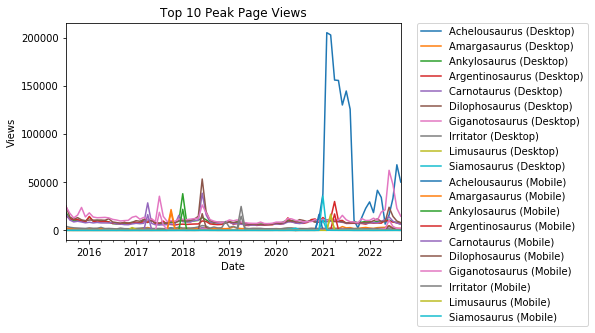

In [463]:
desktop_max_views_indexed.groupby('article')['views'].plot(legend = True)
mobile_max_views_indexed.groupby('article')['views'].plot(legend = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Date")
plt.ylabel("Views")
plt.title("Top 10 Peak Page Views")
plt.savefig('Top_10_Peak_Views.png', bbox_inches='tight')
plt.show()

#### Fewest Months of Data Plot

The third and final analysis I will conduct will look at the articles that have the fewest months of available data for mobile and desktop access. I will identify these articles by grouping by the timestamp variable and counting how many months of data they have. I will then sort the data to identify the indexes where the ten lowest months of data are located. I will match these indexes with the article titles in the object and then filter the dataframe to only include articles in the list of those with the fewest months of data. 

In [ ]:
mobile = mobile.reset_index()
desktop = desktop.reset_index()

In [ ]:
# count the months of data each article has in the mobile dataset 
mobile_months_of_data = mobile.groupby('article')['timestamp'].count()

# identify which locations have the fewest months of data 
idx = np.argpartition(mobile_months_of_data, 10)
mobile_months_of_data_min = mobile_months_of_data[idx[:10]]

# match the article names in the array to the indexes identified to obtain a list of the articles with the ten fewest months of data
length = len(mobile.article)
indexes = []
for x in range(1, length-1): 
        result = mobile.article[x] in mobile_months_of_data_min.index
        if(result == True): 
            indexes.append(x)

# filter the dataframe to only include articles that are in the list of the ten fewest months of data 
mobile_subset = mobile[mobile.index.isin(indexes) ]
mobile_subset = mobile_subset.set_index('timestamp')

# add a suffix to the article title to provide clarity in the plot 
suffix = ' (Mobile)'
mobile_subset.article = [title + suffix for title in mobile_subset.article]

In [ ]:
# count the months of data each article has in the desktop dataset 
desktop_months_of_data = desktop.groupby('article')['timestamp'].count()

# identify which locations have the fewest months of data 
idx = np.argpartition(desktop_months_of_data, 10)
desktop_months_of_data_min = desktop_months_of_data[idx[:10]]

# match the article names in the array to the indexes identified to obtain a list of the articles with the ten fewest months of data
length = len(desktop.article)
indexes = []
for x in range(1, length-1): 
        result = desktop.article[x] in desktop_months_of_data_min.index
        if(result == True): 
            indexes.append(x)

# filter the dataframe to only include articles that are in the list of the ten fewest months of data 
desktop_subset = desktop[desktop.index.isin(indexes) ]
desktop_subset = desktop_subset.set_index('timestamp')

# add a suffix to the article title to provide clarity in the plot 
suffix = ' (Desktop)'
desktop_subset.article = [title + suffix for title in desktop_subset.article]

Once I have obtained a dataframe for both access types that includes the timeseries data for only the articles with the ten fewest months of available data, I will plot both the desktop and mobile timeseries data and save the plot in the Fewest_Months_Of_Data.png file. 

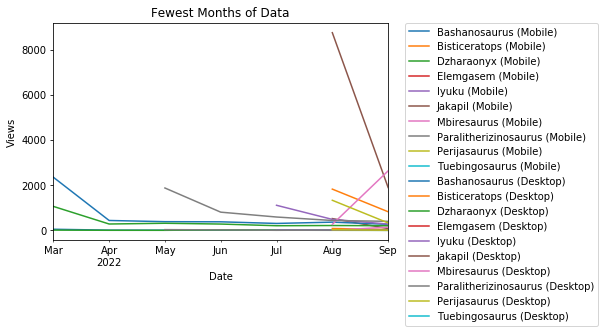

In [464]:
mobile_subset.groupby('article')['views'].plot(legend = True)
desktop_subset.groupby('article')['views'].plot(legend = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Date")
plt.ylabel("Views")
plt.title("Fewest Months of Data")
plt.savefig('Fewest_Months_Of_Data.png', bbox_inches='tight')
plt.show()